In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys
import itertools

from utilities2015 import *

from joblib import Parallel, delayed

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
section_id = 100

dm = DataManager(stack='MD593', section=section_id, segm_params_id='gridsize200')

# dm._load_image()

texton_hists = dm.load_pipeline_result('texHist')
textonmap = dm.load_pipeline_result('texMap')
n_texton = textonmap.max() + 1

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [3]:
single_channel_maps = [textonmap[dm.ymin:dm.ymax+1, dm.xmin:dm.xmax+1]==c for c in range(n_texton)]

In [4]:
from skimage.transform import integral_image

In [5]:
int_imgs = np.dstack(Parallel(n_jobs=4)(delayed(integral_image)(m) for m in single_channel_maps))

In [12]:
def hist_centered_at(x,y,grid_size):
    hist = int_imgs[y-grid_size/2, x-grid_size/2] + int_imgs[y+grid_size/2, x+grid_size/2] - \
            int_imgs[y+grid_size/2, x-grid_size/2] - int_imgs[y-grid_size/2, x+grid_size/2]
    return hist/float(hist.sum())

In [58]:
def compute_best_scale(pts):

    best_gs_list = np.empty((pts.shape[0],), np.int)
    for pt_i, (x, y) in enumerate(pts):
        energies = np.empty((len(grid_sizes),))

        for i, grid_size in enumerate(grid_sizes):
            
            if x - 3*grid_size/2 < 0 or x + 3*grid_size/2 >= dm.w or \
            y - 3*grid_size/2 < 0 or y + 3*grid_size/2 >= dm.h:
                energies[i] = np.nan
            else:
                int_hist = hist_centered_at(x,y,grid_size)
                neighbor_hists = [hist_centered_at(xn, yn, grid_size) 
                                  for xn, yn in [(x-grid_size,y-grid_size),(x-grid_size,y),(x-grid_size,y+grid_size),
                                                 (x, y-grid_size), (x, y+grid_size),
                                                (x+grid_size,y-grid_size),(x+grid_size,y),(x+grid_size,y+grid_size)]]
                d = np.squeeze(chi2s(int_hist, neighbor_hists)).min()
                q = int_hist[int_hist!=0]
                entropy = np.sum(q*np.log(q))
                energies[i] = d - 0*entropy
            
        try:
            best_gs_list[pt_i] = grid_sizes[np.nanargmin(energies)]
        except:
            print x,y,grid_size
            raise
    
    return best_gs_list

In [63]:
t = time.time()

grid_sizes = np.arange(50, 500, 10).astype(np.int)

ys, xs = np.mgrid[4725-dm.ymin:4725-dm.ymin+1150:10, 1480-dm.xmin:1480-dm.xmin+1413:10]
    
res = Parallel(n_jobs=16)(delayed(compute_best_scale)(pts) for pts in np.array_split(np.c_[xs.flat, ys.flat], 16))

print time.time() - t, 'seconds'

11.5237579346 seconds


In [64]:
gs_map = np.reshape(np.concatenate(res), xs.shape)

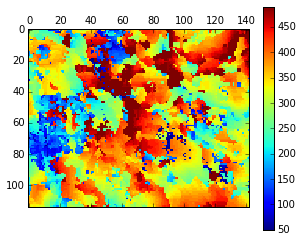

In [65]:
plt.matshow(gs_map);
plt.colorbar();

In [59]:
compute_best_scale(np.array([np.array([8890,3308])-(dm.xmin, dm.ymin)]))

array([360])

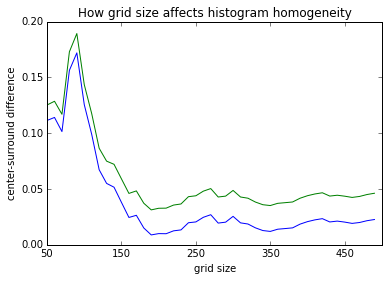

In [105]:
plt.plot(grid_sizes, ds);
plt.plot(grid_sizes, energies, 'g')
# plt.plot(grid_sizes, entropies, 'r');
plt.xlabel('grid size');
plt.xticks(grid_sizes[::10]);
plt.ylabel('center-surround difference');
plt.title('How grid size affects histogram homogeneity');

In [106]:
best_gs = grid_sizes[np.argmin(energies)]
print best_gs

190


In [20]:
dm._load_image(versions=['rgb-jpg'])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2261: DecompressionBombWarning: Image size (203470848 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [21]:
import cv2

In [101]:
viz = dm.image_rgb_jpg.copy()
cv2.rectangle(viz, (x-best_gs/2, y-best_gs/2), (x+best_gs/2, y+best_gs/2), (255,0,0), 10)

In [102]:
display(viz[dm.ymin:dm.ymax, dm.xmin:dm.xmax])

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [66]:
section_id = 100

dm = DataManager(stack='MD593', section=section_id,
                 labeling_dir='/home/yuncong/CSHL_data_labelings')

# dm._load_image()

# texton_hists = dm.load_pipeline_result('texHist')
# segmentation = dm.load_pipeline_result('segmentation')
# n_superpixels = segmentation.max() + 1
textonmap = dm.load_pipeline_result('texMap')
n_texton = textonmap.max() + 1
# neighbors = dm.load_pipeline_result('neighbors')

# neighbors_global = neighbors

# texture_map = texton_hists[segmentation]
# texture_map[~dm.mask] = np.nan * np.ones((n_texton,))
# dm.save_pipeline_result(texture_map, 'textureMap', 'npy')

# texture_map = dm.load_pipeline_result('textureMap', 'npy')

# coherence_map = dm.load_pipeline_result('coherenceMap', 'npy')
# eigenvec_map = dm.load_pipeline_result('eigenvecMap', 'npy')

# origPosCanvas = dm.load_pipeline_result('originPosOnCanvas', 'npy')

In [99]:
labeling_name = 'MD593_0100_yuncong_09202015173615'
label = 0
with open('/home/yuncong/csd395/CSHL_data_landmarks/%s_landmark_%d.pkl'%(labeling_name, label), 'r') as f:
    descriptor = pickle.load(f)

In [100]:
d = descriptor[4]

In [134]:
from skimage.segmentation import relabel_sequential

variances = []
grid_sizes = np.linspace(100, min(d['height'], d['width'])/2, 100).astype(np.int)

for grid_size in grid_sizes:

    segmentation = np.zeros((d['height'], d['width']), np.int16)
    rss, css = np.mgrid[0:d['height']:grid_size, 0:d['width']:grid_size]
    for gi, (rs, cs) in enumerate(zip(rss.flat, css.flat)):
        segmentation[rs:rs+grid_size, cs:cs+grid_size] = gi

    segmentation[~d['mask']] = -1
    segmentation[textonmap[d['ymin']:d['ymax']+1, d['xmin']:d['xmax']+1]==-1] = -1
    
    # segmentation starts from 0
    masked_segmentation_relabeled, _, _ = relabel_sequential(segmentation + 1)

    # make background label -1
    segmentation = masked_segmentation_relabeled - 1
    n_superpixels = segmentation.max() + 1

    texton_hists_lm = np.array([np.bincount(textonmap[d['ymin']:d['ymax']+1, d['xmin']:d['xmax']+1][segmentation == s],
                                   minlength=n_texton) for s in range(n_superpixels)])
    texton_hists_lm = texton_hists_lm/texton_hists_lm.sum(axis=1)[:,None].astype(np.float)

    ds = cdist(texton_hists_lm, texton_hists_lm, chi2)
    if grid_size == 734 or grid_size == 726:
        print ds
    variances.append(ds.max())
    
#     ds = chi2s([texton_hists_lm.mean(axis=0)], texton_hists_lm)
#     print grid_size, ds
#     variances.append(ds.mean())
    
#     var = np.sum(ds**2)/len(ds)
#     variances.append(var)

[[ 0.          0.02998264  0.16689897  0.08930196  0.12618042  0.85797037
   0.07639761  0.04527023  0.95474459]
 [ 0.02998264  0.          0.2290952   0.08652     0.12595624  0.75478485
   0.07479392  0.03761827  0.98753885]
 [ 0.16689897  0.2290952   0.          0.07834996  0.07753089  0.89785424
   0.09745738  0.16454741  1.38706358]
 [ 0.08930196  0.08652     0.07834996  0.          0.00963695  0.75706244
   0.00661791  0.04538917  1.3188952 ]
 [ 0.12618042  0.12595624  0.07753089  0.00963695  0.          0.79813674
   0.0163599   0.06046581  1.36556138]
 [ 0.85797037  0.75478485  0.89785424  0.75706244  0.79813674  0.
   0.7417143   0.73206932  1.339045  ]
 [ 0.07639761  0.07479392  0.09745738  0.00661791  0.0163599   0.7417143
   0.          0.02941098  1.25472935]
 [ 0.04527023  0.03761827  0.16454741  0.04538917  0.06046581  0.73206932
   0.02941098  0.          1.08152762]
 [ 0.95474459  0.98753885  1.38706358  1.3188952   1.36556138  1.339045
   1.25472935  1.08152762  0.    

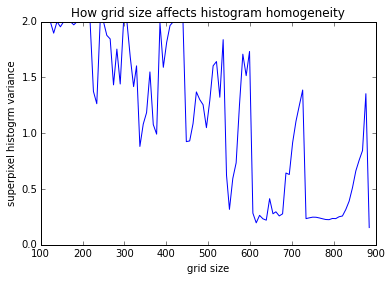

In [135]:
plt.plot(grid_sizes, variances);
plt.xlabel('grid size');
# plt.xticks(grid_sizes[::10]);
plt.ylabel('superpixel histogrm variance');
plt.title('How grid size affects histogram homogeneity');

In [103]:
grid_sizes[np.argsort(variances)]

array([885, 615, 734, 773, 781, 742, 750, 758, 789, 766, 797, 805, 631,
       813, 821, 639, 623, 829, 607, 655, 670, 662, 837, 551, 678, 647,
       845, 686, 694, 559, 853, 544, 456, 377, 337, 567, 861, 464, 369,
       869, 496, 226, 322, 702, 472, 448, 480, 488, 345, 329, 234, 393,
       710, 314, 353, 512, 401, 504, 361, 718, 520, 385, 282, 258, 274,
       266, 242, 575, 290, 179, 203, 591, 187, 171, 147, 306, 155, 528,
       298, 599, 536, 409, 877, 123, 139, 195, 250, 425, 131, 218, 211,
       583, 433, 163, 115, 726, 417, 107, 440, 100])

In [115]:
grid_size = 726

segmentation = np.zeros((d['height'], d['width']), np.int16)
rss, css = np.mgrid[0:d['height']:grid_size, 0:d['width']:grid_size]
for gi, (rs, cs) in enumerate(zip(rss.flat, css.flat)):
    segmentation[rs:rs+grid_size, cs:cs+grid_size] = gi

segmentation[~d['mask']] = -1
from skimage.segmentation import relabel_sequential

# segmentation starts from 0
masked_segmentation_relabeled, _, _ = relabel_sequential(segmentation + 1)

# make background label -1
segmentation = masked_segmentation_relabeled - 1

In [116]:
# from skimage.segmentation import mark_boundaries
# dm._load_image(versions=['rgb-jpg'])

In [117]:
img = dm.image_rgb_jpg[d['ymin']:d['ymax']+1, d['xmin']:d['xmax']+1].copy()
viz = mark_boundaries(img, segmentation, background_label=-1)
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg